In [1]:
# Installing the required pacakges

!pip install torch torchvision scikit-learn matplotlib seaborn tqdm pillow pandas

In [3]:
# importing the python libraries

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
from torchvision.models import resnet18,ResNet18_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from IPython.display import display
from IPython.display import Image as Img


import os, sys, math, random
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

In [4]:
# setting random seed
_=torch.manual_seed(42)

In [5]:
# downloading the dataset

eurosat_dataset = datasets.EuroSAT(root="./", download=True, transform=transforms.ToTensor())
image, label = eurosat_dataset[0]

print("Number of samples:", len(eurosat_dataset))
print("Number of Classes:", len(eurosat_dataset.classes))
print("Shape of the image:", image.shape)
print("Classes:", eurosat_dataset.classes)

100%|██████████| 94.3M/94.3M [00:01<00:00, 58.0MB/s]


Number of samples: 27000
Number of Classes: 10
Shape of the image: torch.Size([3, 64, 64])
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [6]:
# checking the image dimensions and their corresponding labels

classes = eurosat_dataset.classes

rows = []
for i in range(len(eurosat_dataset)):
    img, label = eurosat_dataset[i]
    arr = np.array(img.permute(1,2,0) * 255).astype(np.uint8) if isinstance(img, torch.Tensor) else np.array(img)
    h,w = arr.shape[0], arr.shape[1]
    rows.append({"index": i, "label": int(label), "h": h, "w": w})

df = pd.DataFrame(rows)
df['class_name'] = df['label'].apply(lambda x: classes[x] if classes else str(x))
print("========== Image Dimensions and Class Labels for EuroSAT Dataset ==========\n")
print(df)

========== Image Dimensions and Class Labels for EuroSAT Dataset ==========

       index  label   h   w  class_name
0          0      0  64  64  AnnualCrop
1          1      0  64  64  AnnualCrop
2          2      0  64  64  AnnualCrop
3          3      0  64  64  AnnualCrop
4          4      0  64  64  AnnualCrop
...      ...    ...  ..  ..         ...
26995  26995      9  64  64     SeaLake
26996  26996      9  64  64     SeaLake
26997  26997      9  64  64     SeaLake
26998  26998      9  64  64     SeaLake
26999  26999      9  64  64     SeaLake

[27000 rows x 5 columns]


In [7]:
# class distribution

dist = df['class_name'].value_counts().reset_index()
print("========== Class Distribution ==========\n")
print(dist)

========== Class Distribution ==========

             class_name  count
0            AnnualCrop   3000
1                Forest   3000
2  HerbaceousVegetation   3000
3           Residential   3000
4               SeaLake   3000
5               Highway   2500
6            Industrial   2500
7         PermanentCrop   2500
8                 River   2500
9               Pasture   2000


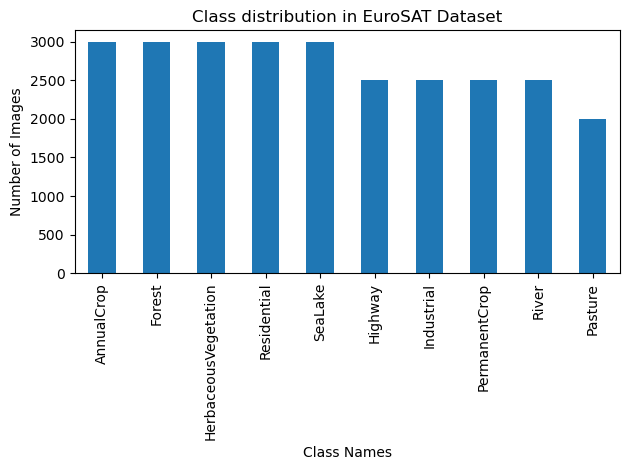

In [8]:
# plotting the class label and its corresponding count as bar chart

counts = df["class_name"].value_counts()

counts.plot(kind="bar")
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Class distribution in EuroSAT Dataset")
plt.tight_layout()
# plt.savefig("class_distribution.png")
plt.show()

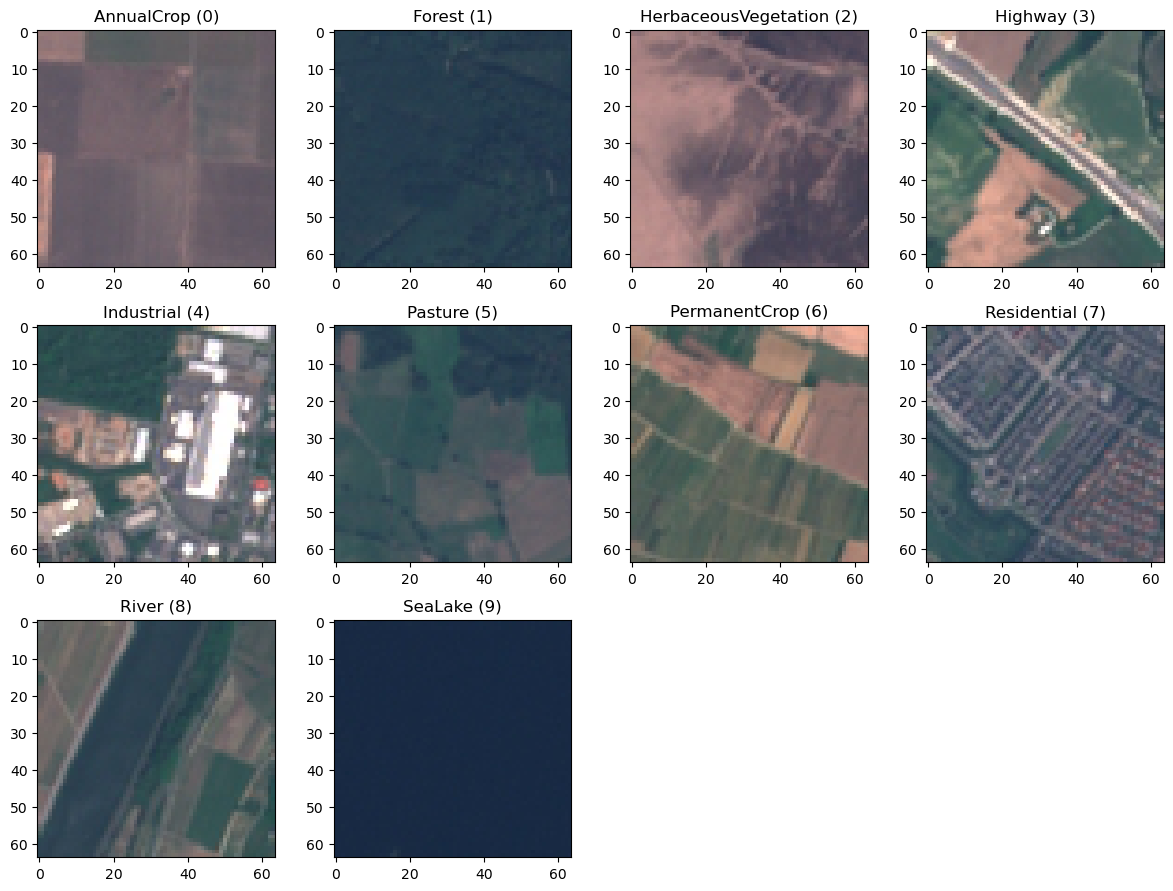

In [8]:
# showing the images present in the dataset

n_classes=10
ncols=4
samples = (df.groupby('class_name')['index'].first())

imgs, titles = [], []
for cname, idx in samples.items():
    img, label = eurosat_dataset[idx]
    if isinstance(img, torch.Tensor):
        img = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    else:
        img = np.array(img)
    imgs.append(img)
    titles.append(f"{cname} ({label})")

nrows = math.ceil(len(imgs) / ncols)
plt.figure(figsize=(12, 9))
for i, (img, title) in enumerate(zip(imgs, titles)):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(img)
    plt.title(title)
plt.tight_layout()
# plt.savefig("class_images.png")
plt.show()

Explained Variance PCA: [0.64882326 0.02712484]


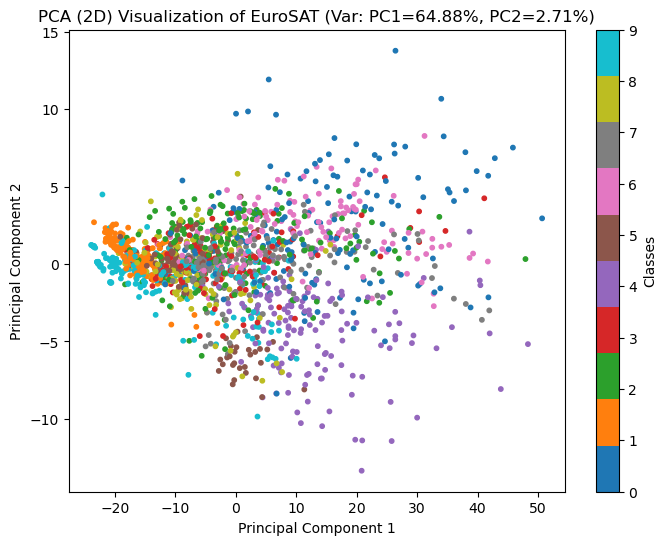

In [27]:
# PCA for 2D Data Visualization

N = 1500
indices = random.sample(range(len(eurosat_dataset)), N) # using this to shuffle int images, and not consider first 1500 images

subset_img = []
subset_label = []

for idx in indices:
    img, lbl = eurosat_dataset[idx]
    subset_img.append(img.view(-1).numpy()) 
    subset_label.append(lbl)

subset_img = np.array(subset_img)


pca = PCA(n_components=2)
pca_out = pca.fit_transform(subset_img)

expl_var = pca.explained_variance_ratio_
print("Explained Variance PCA:", expl_var)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_out[:, 0], pca_out[:, 1], c=subset_label, cmap="tab10", s=10)
plt.title(f"PCA (2D) Visualization of EuroSAT (Var: PC1={expl_var[0]*100:.2f}%, PC2={expl_var[1]*100:.2f}%)")


plt.colorbar(scatter, ticks=range(len(classes)), label="Classes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
# plt.savefig("pca.png")
plt.show()

In [9]:
# Dividing the dataset: 70% train and 30% validation and test split

train_size=int(0.7*len(eurosat_dataset))
val_size=int(0.15* len(eurosat_dataset))
test_size=len(eurosat_dataset) - train_size - val_size

print(f"length of training_dataset is:{train_size}")
print(f"length of validation set is: {val_size}")
print(f"length of test dataset: {test_size}")

length of training_dataset is:18900
length of validation set is: 4050
length of test dataset: 4050


In [11]:
# Applying transformers and creating the dataloader

train_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225])
    ])

val_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225] 
    )])


train_dataset, val_dataset,test_dataset=random_split(eurosat_dataset,[train_size,val_size,test_size])

# applying transforms
train_dataset.dataset.transform=train_transforms
val_dataset.dataset.transform=val_transforms
test_dataset.dataset.transform=val_transforms

# dataloader
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=4)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=False,num_workers=4)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False,num_workers=4)

#device --> use gpu if a CUDA enabled device
device=torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Defining the Model

## Model Ideation

We use a **ResNet-18** pretrained with ImageNet weights as a backbone, for classification \
Instead of its original fully connected layer for 1000 ImageNet classes, we add a small custom head for our classification task 

Details of our custom head: 
* We first take the input 512 feature vector (also the output of average pooling) as input to our custom head 
* We project this 512 feature vectors to 256 dim via a fully connected layer 
* ReLU activation for non-linearity followed by dropout for better generalization is added 
* Final fully connected layer converts this 256 dim feature vector to **10 dim** feature vector (same number as our output classes)

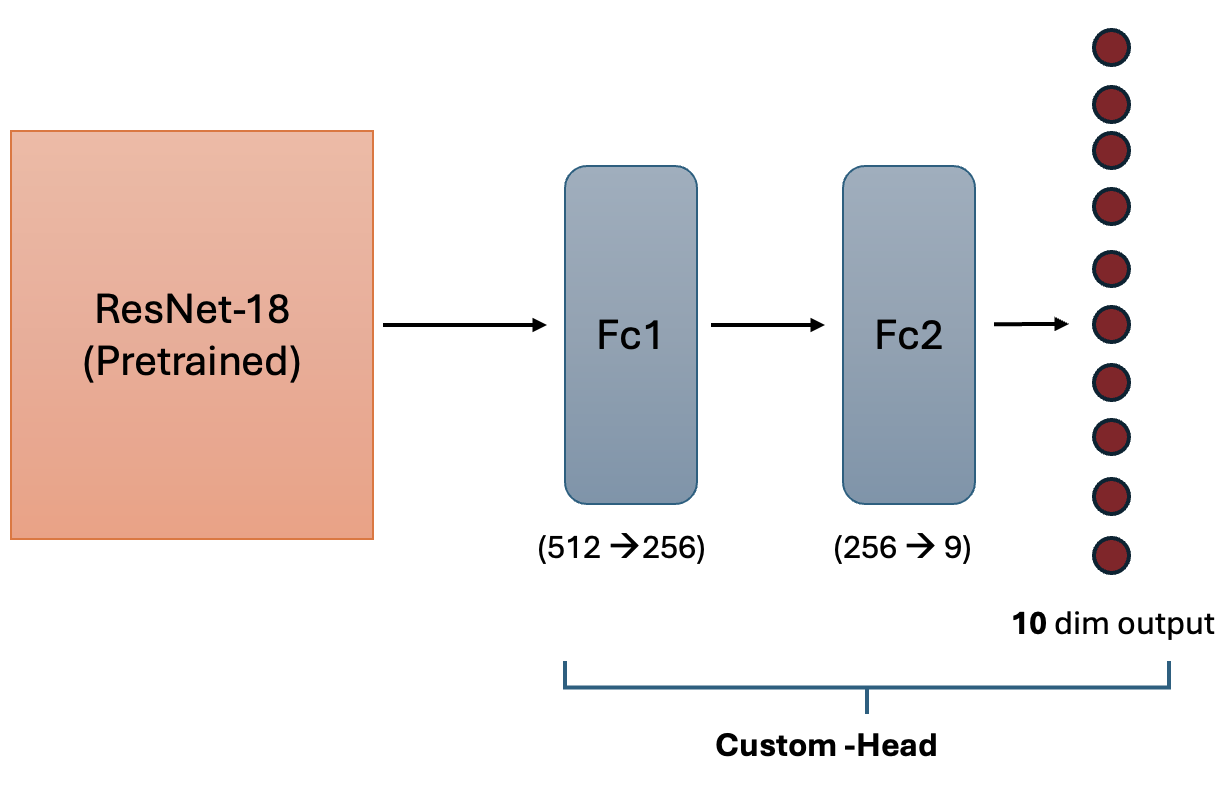

In [12]:
display(Img(filename="./Images/Resnet_18_custom_head.png", width=500, height=350))

## Model Implementation and Technical Specifications
** We freeze layers 1-3 for Resnet and only layer 4 **(containing the last 4 Convolution layers)** + custom head is trainable \
** Total number of trainable parameters **~8.5M** \
** We train our model for 10 epochs \
** Loss used is **CrossEntropy**  \
** We use AdamW optimizer for weight updates 

========== Resnet-18 model ==========



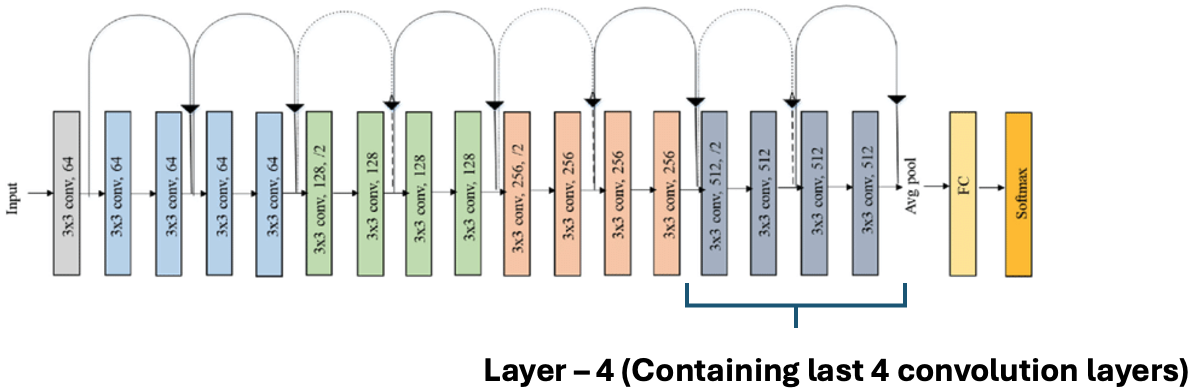


** ------- Final Training Pipeline ---------- **



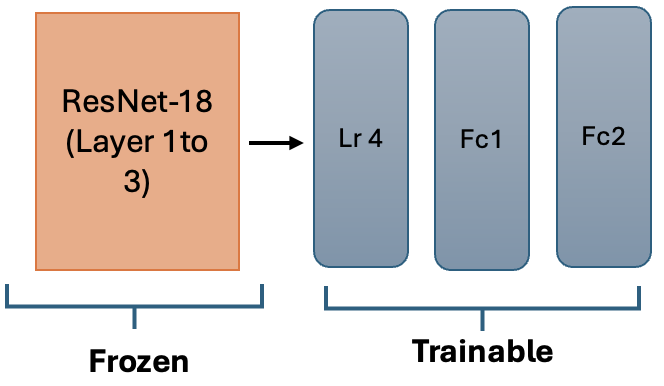

In [13]:
print ("========== Resnet-18 model ==========\n")
display(Img(filename="./Images/Resnet.png", width=400, height=250))

print ("\n** ------- Final Training Pipeline ---------- **\n")
display(Img(filename="./Images/Train_Pipeline_1.png", width=400, height=250))

In [17]:
class MultiClassSingleLabelModel(nn.Module):
    def __init__(self):
        super().__init__()
        backbone=resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        input_dim=backbone.fc.in_features # input features of the last fully connected layer of resnet which is 512
        backbone.fc=nn.Identity() # basically same feature input 512 dimensions is passed as an output instead of the 1000 (used for ImageNet classes)
        self.backbone=backbone
        self.head=nn.Sequential( # new head for multi -label classification
            nn.Linear(input_dim,256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # improve generalization
            nn.Linear(256,10) # 10 is length of classes
        )

    def forward(self,x):
        feature=self.backbone(x)
        return self.head(feature)    

In [18]:
# Initializing the model loss and optimizer

model=MultiClassSingleLabelModel().to(device)

# freezing conv1+ layer1 + layer 2 + layer 3 for resnet
for p in model.backbone.parameters():
    p.requires_grad=False
head_param_count=sum(x.numel() for x in model.parameters() if x.requires_grad) # counting custom head params
for p in model.backbone.layer4.parameters():
    p.requires_grad=True
#----- At this point layer 4 (resnet) + custom head is trainable ---- #

train_params=[x for x in model.parameters() if x.requires_grad]
trainable_count=sum(x.numel() for x in model.parameters() if x.requires_grad) # counting total trainable params
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(train_params,lr=3e-4,weight_decay=1e-3)

print("Total number of Trainable parameters are:",trainable_count)

Total number of Trainable parameters are: 8527626


### Hyperparameter Tuning  -> Using validation set

In [19]:
# Training loop for Hyperparameter tuning

def train(train_Loader:DataLoader,val_loader:DataLoader,model:nn.Module,train_params,epochs=3,lr=3e-4):
    criterion=nn.CrossEntropyLoss()
    optimizer=torch.optim.AdamW(train_params,lr=lr,weight_decay=1e-3)    
    total_epochs=epochs
    model_checkpoint_path=f"./model_checkpoint_{lr}.pkt" # path for saving checkpoint
    train_losses=[] # will be using these for plotting
    val_losses=[]

    print("Started Training")
    for epoch in range(total_epochs):
        loss_per_epoch=0
        model.train()

        data_iterator=tqdm(train_loader,desc=f'Epoch {epoch+1}')
        for image, label in data_iterator:
            image,label=image.to(device),label.to(device) # moving to mps backend
            optimizer.zero_grad() # clearing out all gradients
            prd_class=model(image)
            loss=criterion(prd_class,label)

            loss.backward()
            optimizer.step()

            loss_per_epoch+=loss.item()
        avg_loss=loss_per_epoch/len(data_iterator)
        train_losses.append(avg_loss)

        print(f"Epoch:{epoch+1} Avg Training Loss: {avg_loss:.6f}")
        # validating after each epoch
        model.eval()
        val_loss=0
        with torch.no_grad():
            for image,label in val_loader:
                image,label=image.to(device),label.to(device)
                prd_class=model(image)
                loss=criterion(prd_class,label)
                val_loss+=loss
        avg_val_loss=val_loss/len(val_loader)
        print(f"Epoch:{epoch+1} Validation Loss:{avg_val_loss:.6f}")
        val_losses.append(avg_val_loss.detach().cpu().item())

    # Plotting training and validation losses
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))  # 1 row, 2 columns

    # Train Loss 
    axs[0].plot(range(total_epochs), train_losses, label='Train Loss', color='blue', marker='o')
    axs[0].set_title(f'Training Loss per Epoch with lr:{lr}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].grid(True)

    # Validation Loss
    axs[1].plot(range(total_epochs), val_losses, label='Val Loss', color='red', marker='o')
    axs[1].set_title(f'Validation Loss per Epoch with lr:{lr}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()    

    # saving the model for testing submission 
    torch.save(model.state_dict(),model_checkpoint_path)
    print(f"Training done and model saved for lr: {lr}")


--------- Training for Lr ------->:0.001
Started Training


Epoch 1: 100%|████████████████████████████████| 591/591 [01:21<00:00,  7.23it/s]

Epoch:1 Avg Training Loss: 0.337649


Epoch:1 Validation Loss:0.113294


Epoch 2: 100%|████████████████████████████████| 591/591 [01:22<00:00,  7.19it/s]

Epoch:2 Avg Training Loss: 0.183750


Epoch:2 Validation Loss:0.115466


Epoch 3: 100%|████████████████████████████████| 591/591 [01:26<00:00,  6.83it/s]

Epoch:3 Avg Training Loss: 0.150135


Epoch:3 Validation Loss:0.093322


Epoch 4: 100%|████████████████████████████████| 591/591 [01:30<00:00,  6.50it/s]

Epoch:4 Avg Training Loss: 0.116635


Epoch:4 Validation Loss:0.085533


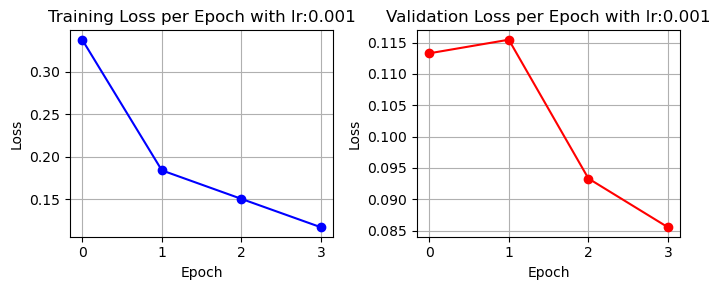

Training done and model saved for lr: 0.001
--------- Training for Lr ------->:0.0004
Started Training


Epoch 1: 100%|████████████████████████████████| 591/591 [01:35<00:00,  6.18it/s]

Epoch:1 Avg Training Loss: 0.299764


Epoch:1 Validation Loss:0.147919


Epoch 2: 100%|████████████████████████████████| 591/591 [01:37<00:00,  6.06it/s]

Epoch:2 Avg Training Loss: 0.139071


Epoch:2 Validation Loss:0.112340


Epoch 3: 100%|████████████████████████████████| 591/591 [01:38<00:00,  6.01it/s]

Epoch:3 Avg Training Loss: 0.095294


Epoch:3 Validation Loss:0.096644


Epoch 4: 100%|████████████████████████████████| 591/591 [01:37<00:00,  6.04it/s]

Epoch:4 Avg Training Loss: 0.078286


Epoch:4 Validation Loss:0.090537


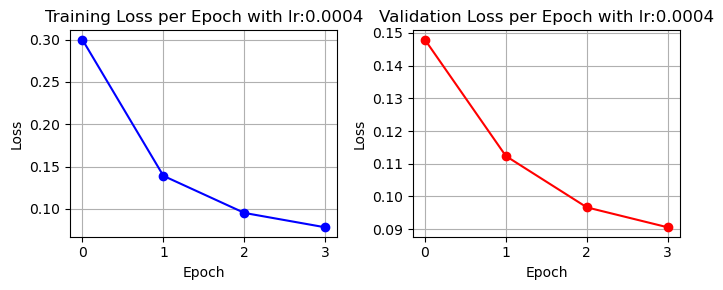

Training done and model saved for lr: 0.0004
--------- Training for Lr ------->:0.0001
Started Training


Epoch 1: 100%|████████████████████████████████| 591/591 [01:47<00:00,  5.52it/s]

Epoch:1 Avg Training Loss: 0.344990


Epoch:1 Validation Loss:0.079237


Epoch 2: 100%|████████████████████████████████| 591/591 [01:56<00:00,  5.08it/s]

Epoch:2 Avg Training Loss: 0.113728


Epoch:2 Validation Loss:0.073854


Epoch 3: 100%|████████████████████████████████| 591/591 [01:55<00:00,  5.10it/s]

Epoch:3 Avg Training Loss: 0.061750


Epoch:3 Validation Loss:0.078880


Epoch 4: 100%|████████████████████████████████| 591/591 [01:49<00:00,  5.38it/s]

Epoch:4 Avg Training Loss: 0.047860


Epoch:4 Validation Loss:0.090088


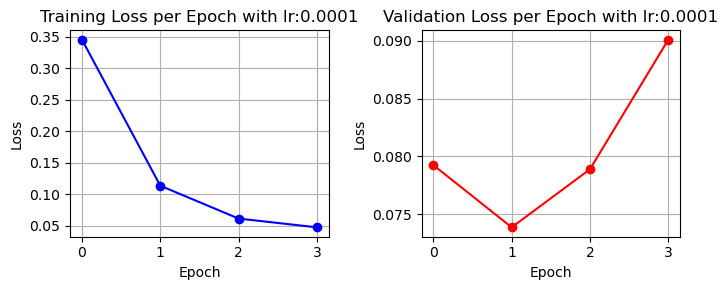

Training done and model saved for lr: 0.0001
--------- Training for Lr ------->:1e-05
Started Training


Epoch 1: 100%|████████████████████████████████| 591/591 [01:48<00:00,  5.45it/s]

Epoch:1 Avg Training Loss: 1.210035


Epoch:1 Validation Loss:0.396300


Epoch 2: 100%|████████████████████████████████| 591/591 [01:44<00:00,  5.67it/s]

Epoch:2 Avg Training Loss: 0.383360


Epoch:2 Validation Loss:0.171203


Epoch 3: 100%|████████████████████████████████| 591/591 [01:55<00:00,  5.12it/s]

Epoch:3 Avg Training Loss: 0.242698


Epoch:3 Validation Loss:0.123909


Epoch 4: 100%|████████████████████████████████| 591/591 [01:44<00:00,  5.65it/s]

Epoch:4 Avg Training Loss: 0.187270


Epoch:4 Validation Loss:0.107731


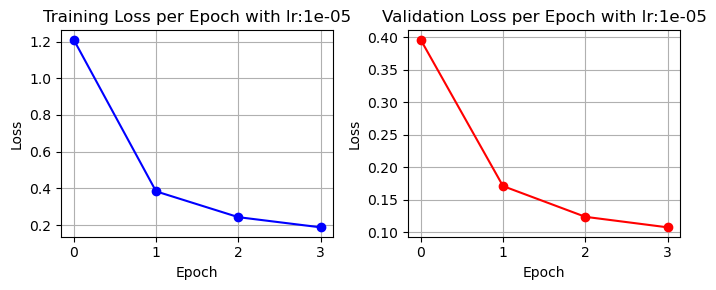

Training done and model saved for lr: 1e-05


In [43]:
# Tuning the learning Rate

learning_rates=[1e-3,4e-4,1e-4,1e-5]

for lr in learning_rates:
    print(f"--------- Training for Lr ------->:{lr}")
    model=MultiClassSingleLabelModel().to(device)
    # freezing conv1+ layer1 + layer 2 + layer 3 for resnet
    for p in model.backbone.parameters():
        p.requires_grad=False
    head_param_count=sum(x.numel() for x in model.parameters() if x.requires_grad) # counting custom head params
    for p in model.backbone.layer4.parameters():
        p.requires_grad=True
        
    #----- At this point layer 4 (resnet) + custom head is trainable ---- #

    train_params=[x for x in model.parameters() if x.requires_grad]
    trainable_count=sum(x.numel() for x in model.parameters() if x.requires_grad) # counting total trainable params

    train(train_loader,val_loader,model,train_params=train_params,epochs=4,lr=lr)


#### Amongst all the learning rates experimented, model trained with lr=1e-5, exhibits a validation loss curve That closely matches with the training loss curve and hence we use to train our model.

--------- Final Training for 10 epochs with Lr ------->:1e-05
Started Training


Epoch 1: 100%|████████████████████████████████| 591/591 [01:40<00:00,  5.89it/s]

Epoch:1 Avg Training Loss: 1.206626


Epoch:1 Validation Loss:0.393423


Epoch 2: 100%|████████████████████████████████| 591/591 [01:51<00:00,  5.31it/s]

Epoch:2 Avg Training Loss: 0.381052


Epoch:2 Validation Loss:0.172830


Epoch 3: 100%|████████████████████████████████| 591/591 [01:43<00:00,  5.72it/s]

Epoch:3 Avg Training Loss: 0.248749


Epoch:3 Validation Loss:0.124741


Epoch 4: 100%|████████████████████████████████| 591/591 [01:43<00:00,  5.70it/s]

Epoch:4 Avg Training Loss: 0.188686


Epoch:4 Validation Loss:0.105378


Epoch 5: 100%|████████████████████████████████| 591/591 [02:02<00:00,  4.81it/s]

Epoch:5 Avg Training Loss: 0.155366


Epoch:5 Validation Loss:0.085864


Epoch 6: 100%|████████████████████████████████| 591/591 [01:54<00:00,  5.14it/s]

Epoch:6 Avg Training Loss: 0.125580


Epoch:6 Validation Loss:0.078250


Epoch 7: 100%|████████████████████████████████| 591/591 [01:59<00:00,  4.93it/s]

Epoch:7 Avg Training Loss: 0.104686


Epoch:7 Validation Loss:0.075872


Epoch 8: 100%|████████████████████████████████| 591/591 [01:49<00:00,  5.38it/s]

Epoch:8 Avg Training Loss: 0.081048


Epoch:8 Validation Loss:0.071752


Epoch 9: 100%|████████████████████████████████| 591/591 [01:48<00:00,  5.47it/s]

Epoch:9 Avg Training Loss: 0.071150


Epoch:9 Validation Loss:0.066973


Epoch 10: 100%|███████████████████████████████| 591/591 [01:48<00:00,  5.44it/s]

Epoch:10 Avg Training Loss: 0.060367


Epoch:10 Validation Loss:0.075721


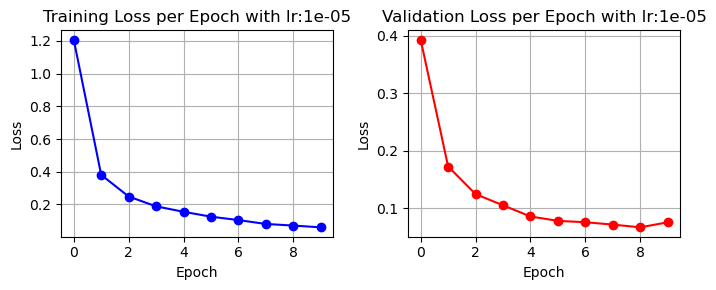

Training done and model saved for lr: 1e-05


In [44]:
# Infering from the above --> we choose lr=1e-5 for final training (10 epochs) and testing

lr=1e-5
print(f"--------- Final Training for 10 epochs with Lr ------->:{lr}")
model=MultiClassSingleLabelModel().to(device)

# freezing conv1+ layer1 + layer 2 + layer 3 for resnet
for p in model.backbone.parameters():
    p.requires_grad=False
head_param_count=sum(x.numel() for x in model.parameters() if x.requires_grad) # counting custom head params
for p in model.backbone.layer4.parameters():
    p.requires_grad=True

#----- At this point layer 4 (resnet) + custom head is trainable ----

train_params=[x for x in model.parameters() if x.requires_grad]
trainable_count=sum(x.numel() for x in model.parameters() if x.requires_grad) # counting total trainable params

train(train_loader,val_loader,model,train_params=train_params,epochs=10,lr=lr)

In [45]:
# Testing the model
# Initialing the model and loading the weights from final trained checkpoint

final_model=MultiClassSingleLabelModel()
final_model.load_state_dict(torch.load("./model_checkpoint_1e-05.pkt"))
final_model.to(device)
final_model.eval()
criterion=nn.CrossEntropyLoss()
test_loss=0
correct = 0
total = 0


with torch.no_grad():
    for images, labels in test_loader:
        images,labels=images.to(device),labels.to(device)
        prd_class=final_model(images)
     
        loss=criterion(prd_class,labels)
        test_loss+=loss.item()

        _, predicted = torch.max(prd_class.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()   

avg_test_loss=test_loss/len(test_loader)
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Final Testing Loss: {avg_test_loss:.6f}")

Test Accuracy: 97.41%
Final Testing Loss: 0.081120


#### Calculating Loss, Accuracy, Precision, Recall, F1 Score and Confusion Matrix for Test Set

In [46]:
def evaluation(model, test_loader, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss=0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            prd_class = model(images)

            loss=criterion(prd_class,labels)
            test_loss+=loss.item()

            preds = torch.argmax(prd_class, dim=1)
            all_preds.extend(preds.cpu().numpy()) # adding all predictions into array
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss=test_loss/len(test_loader)
    # numpy conversion
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Precision, Recall, F1 (using macro which is ==> average over classes)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    print("------ Evaluation Metrics -------")
    print(f"Loss on Test Set: {avg_test_loss:.4f}")
    print(f"Accuracy on Test Set : {accuracy:.4f}")
    print(f"Precision on Test Set: {precision:.4f}")
    print(f"Recall on Test Set  : {recall:.4f}")
    print(f"F1-score on Test Set : {f1:.4f}")

    plt.figure(figsize=(10, 8))
    disp.plot(cmap="Blues", xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, f1


------ Evaluation Metrics -------
Loss on Test Set: 0.0811
Accuracy on Test Set : 0.9741
Precision on Test Set: 0.9738
Recall on Test Set  : 0.9730
F1-score on Test Set : 0.9733


<Figure size 1000x800 with 0 Axes>

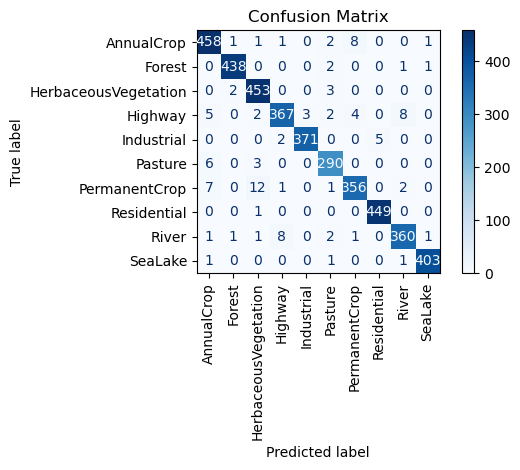

(0.9740740740740741,
 0.9738347178790072,
 0.9730074850977097,
 0.9733412685303993)

In [47]:
final_model=MultiClassSingleLabelModel()
final_model.load_state_dict(torch.load("./model_checkpoint_1e-05.pkt"))
final_model.to(device)
class_names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
evaluation(final_model,test_loader,class_names=class_names)